# Example 12 Singlet fission with bath modes

**This example takes a while. I recommend execution on HPC and select JAX as wrapper**

- References
  - [Chin, Alex W., et al. "Exact mapping between system-reservoir quantum models and semi-infinite discrete chains using orthogonal polynomials." Journal of Mathematical Physics 51.9 (2010).](https://doi.org/10.1063/1.3490188)
  - [Zheng, Jie, et al. "Ultrafast nonadiabatic dynamics of singlet fission: Quantum dynamics with the multilayer multiconfigurational time-dependent Hartree (ML-MCTDH) method." The Journal of Physical Chemistry C 120.3 (2016): 1375-1389.](https://pubs.acs.org/doi/abs/10.1021/acs.jpcc.5b09921)

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

import jax.extend

print(jax.extend.backend.get_backend().platform)

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pytdscf version = 1.0.3
macOS-14.4.1-arm64-arm-64bit
cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import BasInfo, Exciton, Boson, Model, Simulator, units, TensorOperator, TensorHamiltonian

## Model Hamiltonian

$$
H = H_{\text{ele}} + H_{\text{ph}} + H_{\text{el-ph}}
$$

where $H_{\text{ele}}$ is the electronic Hamiltonian consisting of three sites (S1, TT, CS in this order)
and represented by following effective Hamiltonian

$$
H_{\text{ele}} = \begin{pmatrix}
0.2 & 0 & -0.05 \\
0 & 0 & -0.05 \\
-0.05 & -0.05 & 0.3
\end{pmatrix}
$$


and $H_{\text{ph}}$ and $H_{\text{el-ph}}$ are the phonon and electron-phonon coupling Hamiltonians, respectively.

$$
H_{\text{ph}} + H_{\text{el-ph}} 
 = \sum_{k} |k\rangle \langle k| c_0 (b_0 + b_0^\dagger) + \sum_{n=1}^N (\omega_n b_n^\dagger b_n + t_n b_{n+1}^\dagger b_n + t_n b_n^\dagger b_{n+1})
$$

For detail derivation of this reserovir model, please refer to the [reference](https://doi.org/10.1063/1.3490188).

We will set the electronic state as the left terminal site (i=0) and the bath modes as i=1 to N+1 sites.

### Spectral density

The [previous study](https://pubs.acs.org/doi/abs/10.1021/acs.jpcc.5b09921) employed the spectral density defined as Debye type (Lorentzian decaying)
$$
J_{\text{Debye}}(\omega) = \frac{2\lambda \omega \omega_c}{\omega_c^2 + \omega^2}
$$
with a finite cutoff frequency $\omega_c$.

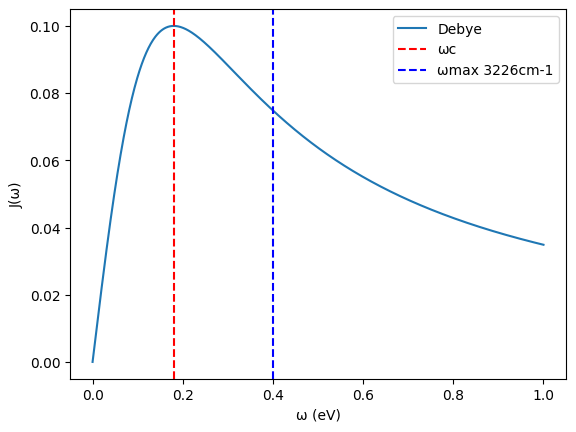

In [3]:
ωc = 0.18  # eV a.k.a cutoff frequency
λ = 0.10  # eV a.k.a reorganization energy
ωmax = 0.40

def J_debye(ω):
    return 2 * λ * ω * ωc / (ω * ω + ωc * ωc)

omega = np.linspace(0.0, 1.0, 1000)
plt.plot(omega, J_debye(omega), label="Debye")
plt.xlabel("ω (eV)")
plt.ylabel("J(ω)")
plt.axvline(x=ωc, color="red", linestyle="--", label="ωc")
plt.axvline(x=ωmax, color="blue", linestyle="--", label="ωmax 3226cm-1")
plt.legend()
plt.show()

The easiest transformation to finite number of harmonic oscillators is just
discretizing integral
$$
\begin{align}
& H_{\text{sys}} + H_{\text{res}} + V
\\
&= 
H_{\text{sys}} 
+ \int_0^{x_{\text{max}}} dx g(x) a_{x} a_{x}^\dagger 
+ \int_0^{x_{\text{max}}} dx h(x) \hat{A} (a_{x} + a_{x}^\dagger)
\\
&\approx
H_{\text{sys}}
+ \sum_{n=1}^N \omega_n a_n^\dagger a_n
+ \sum_{n=1}^N c_n \hat{A} (a_n + a_n^\dagger)
\end{align}
$$
$N$ is usually required to be a hundred number to represent the continuous spectral density.

However, there exists a more sophisticated method to map the continuous spectral density to the discrete chain with nearest neighbor coupling.

## Orthogonal polynomial mapping

We will define spectral density as 
$$
J(\omega) = \frac{2\lambda \frac{\omega}{\omega_c}}{1+\left(\frac{\omega}{\omega_c}\right)^2} \theta\left(\frac{\omega}{\omega_c} - \frac{\omega_{\text{max}}}{\omega_c}\right)
$$
where $\theta(x)$ is the Heaviside step function. 
When we set $g(x) = \omega_c x$ and $x_{\text{max}}=\frac{\omega_{\text{max}}}{\omega_c}$, from the following relation
$$
J(\omega) = \pi h^2\left(\frac{\omega}{\omega_c}\right) \frac{1}{\omega_c},
$$
we can extract constant $C=2\lambda\omega_c / \pi$ and define measure
$$
\mu(x) := \frac{h^2(x)}{C} = \frac{x}{1+x^2} \quad \left(0<x<L=\frac{\omega_{\text{max}}}{\omega_c}\right)
$$
and orthogonal monic polynomials $\{\pi_n\}$ which satisfy
$$
\Braket{\pi_n,\pi_m}_{\mu} = \int_0^L \pi_n(x) \pi_m(x) \mu(x) dx
= \delta_{nm} ||\pi_n||^2
$$
and
$$
\pi_{n+1} = (x-\alpha_n) \pi_n - \beta_n \pi_{n-1}
$$
where $\pi_0 = 1$ and $\pi_{-1} = 0$.

The goal is to find recursion coefficients $\alpha_n$ and $\beta_n$ which satisfy
$$
\alpha_n = \frac{\Braket{x\pi_n, \pi_n}_{\mu}}{\Braket{\pi_n, \pi_n}_{\mu}}
$$
and
$$
\beta_n = \frac{\Braket{\pi_n, \pi_n}_{\mu}}{\Braket{\pi_{n-1}, \pi_{n-1}}_{\mu}}.
$$

First we need to prepare the $k$-th moment of the measure up to $k=2N$.
$$
m_k = \int_0^L x^k \mu(x) dx = 
\int_0^L \frac{x^{k+1}}{1+x^2} dx =
\int_0^{\arctan L} \tan^{k+1}\theta d\theta
$$
$$
m_k = \frac{L^{k}}{k} - m_{k-2}, \quad 
m_0 = -\log(\cos(\arctan(L))) = \frac{1}{2} \log(1+L^2)
, \quad m_1 = L - \arctan L
$$
Then, we determine the coefficients $\alpha_n$ and $\beta_n$ recursively.

Note that recursive calculation tends to accumulate errors, so we will use `mpmath` to calculate the coefficients.

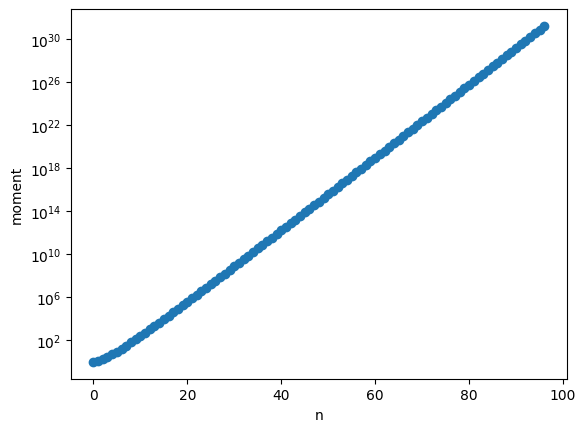

In [4]:
from mpmath import mp, mpf
mp.dps = 512

def get_momments(n_order, L=1.0, factor=1.0): 
    #moments = [mpf(1/2 * math.log(1+L**2)), mpf(L-math.atan(L))]
    moments = [mpf(1) / mpf(2) * mp.log1p(mpf(L) ** 2), mpf(L) - mp.atan(mpf(L))]
    for k in range(2, 2*n_order+1):
        # moments.append(1 / k - moments[-2])
        moments.append(mpf(L) **k / mpf(k) - moments[-2])
    if factor != 1.0:
        factor = mpf(factor)
        moments = [moment * factor ** i for i, moment in enumerate(moments)]
    return moments


n_order = 48
factor = 1.0
L = ωmax / ωc
moments = get_momments(n_order, L, factor)

plt.plot(moments, marker="o")
plt.xlabel("n")
plt.ylabel("moment")
plt.yscale("log")
plt.axhline(0.0, color="black", linestyle="--")
plt.show()

In [5]:
def polynomial_inner_product(poly1: np.ndarray, poly2: np.ndarray, moments: np.ndarray):
    """
    Calculate the inner product of two polynomials using the moments.

    Args:
        poly1: Coefficients of the first polynomial. [1.0, 2.0, 3.0] means 1 + 2x + 3x^2
        poly2: Coefficients of the second polynomial. [1.0, 2.0, 3.0] means 1 + 2x + 3x^2
        moments: Moments used to calculate the inner product.
    """
    assert len(poly1) + len(poly2) - 1 <= len(moments)
    # convolution = np.convolve(poly1, poly2)
    # return np.dot(convolution, moments[:len(convolution)])
    convolution = [mpf(0)] * (len(poly1) + len(poly2) - 1)
    for i in range(len(poly1)):
        for j in range(len(poly2)):
            convolution[i+j] += poly1[i] * poly2[j]
    return sum(c *m for c,m in zip(convolution, moments[:len(convolution)]))


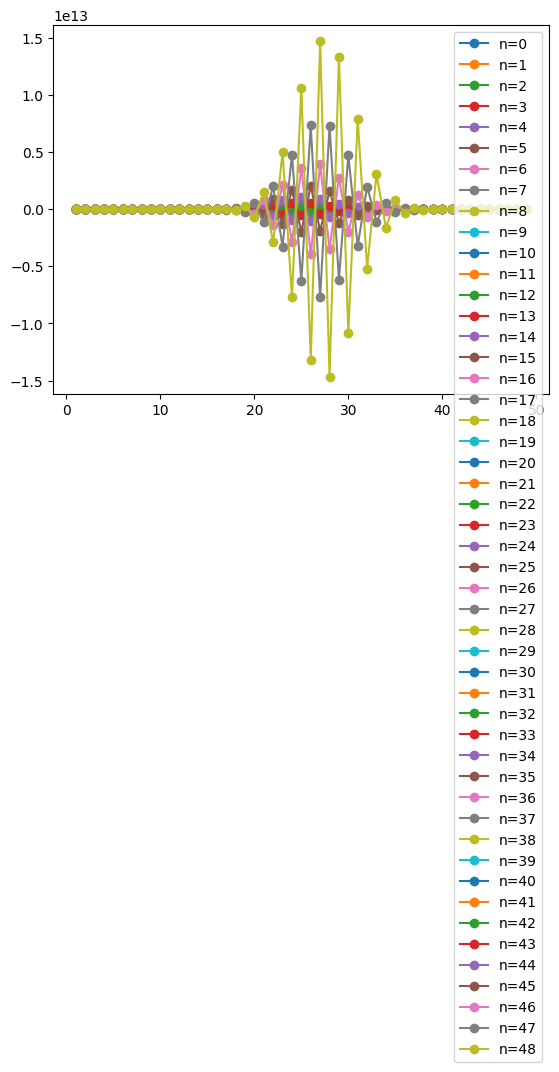

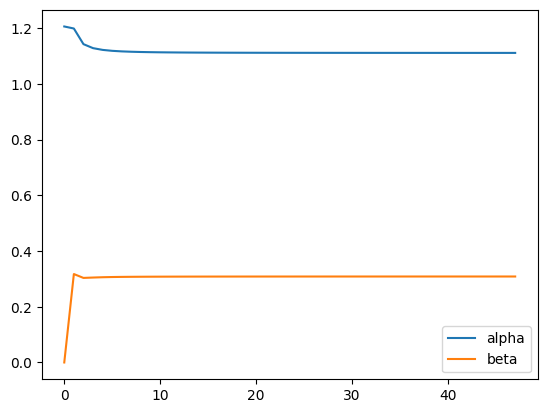

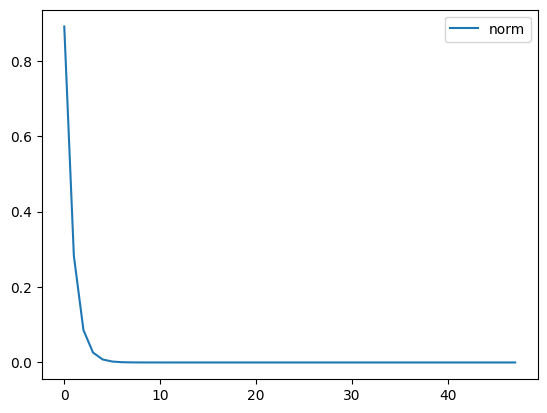

In [6]:

def get_coef_alpha_beta_recursive(n_order, moments):
    # monic_coefs = [[1.0]]
    monic_coefs = [[mpf(1)]]
    alpha = []
    beta = []
    norm = [] # <pi_k,pi_k>
    for n in range(n_order):
        # coefs_pi_k = [0.0] + monic_coefs[-1]
        coefs_pi_k = [mpf(0)] + monic_coefs[-1]
        # coefs_x_pi_k = monic_coefs[-1] + [0.0]
        coefs_x_pi_k = monic_coefs[-1] + [mpf(0)]
        assert coefs_x_pi_k[0] == 1.0
        # <pi_k,pi_k>
        alpha_denom = polynomial_inner_product(np.array(coefs_pi_k)[::-1], np.array(coefs_pi_k)[::-1], np.array(moments))
        # <x pi_k,pi_k>
        alpha_num = polynomial_inner_product(np.array(coefs_x_pi_k)[::-1], np.array(coefs_pi_k)[::-1], np.array(moments))
        alpha.append(alpha_num / alpha_denom)
        norm.append(alpha_denom)
        if n >= 1:
            beta_num = norm[-1]
            beta_denom = norm[-2]
            beta.append(beta_num / beta_denom)
        else:
            # beta.append(0.0)
            beta.append(mpf(0))
        monic_coefs.append(coefs_x_pi_k)
        for i in range(len(monic_coefs[-2])):
            monic_coefs[-1][-i-1] -= alpha[-1] * monic_coefs[-2][-i-1]
        if n >= 1:
            for i in range(len(monic_coefs[-3])):
                monic_coefs[-1][-i-1] -= beta[-1] * monic_coefs[-3][-i-1]
    return monic_coefs, alpha, beta, norm

monic_coefs, alpha, beta, norm = get_coef_alpha_beta_recursive(n_order, moments)

# monic_coefをすべてplot (足りない部分は0)
for i in range(len(monic_coefs)):
    plt.plot(np.arange(i+1, 0, -1), monic_coefs[i], label=f"n={i}", marker="o")
plt.legend()
plt.show()

plt.plot(alpha, label="alpha")
plt.plot(beta, label="beta")
plt.legend()
plt.show()

plt.plot(norm, label="norm")
plt.legend()
plt.show()

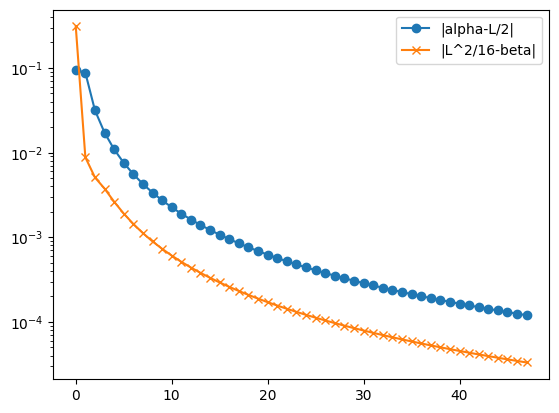

In [7]:
plt.plot(np.abs(np.array(alpha)-L/2), label="|alpha-L/2|", marker="o")
plt.plot(np.abs(L**2/16-np.array(beta)), label="|L^2/16-beta|", marker="x")
plt.yscale("log")
plt.legend()
plt.show()

Then, we have the parameters

$$
c_0 = |\pi_0| = \sqrt{m_0} = \sqrt{\frac{1}{2} \log(1+L^2)}
$$
$$
\omega_n = \omega_c \alpha_n
$$
$$
t_n = \omega_c \sqrt{\beta_{n+1}}
$$

And total Hamiltonian is
$$
H_{\text{sys}} + \sqrt{\frac{\lambda\omega_c\log(1+L^2)}{\pi}} \hat{A} (b_0 + b_0^\dagger) + \sum_{n=0}^N \omega_c(\alpha_n b_n^\dagger b_n + \sqrt{\beta_{n+1}} b_{n+1}^\dagger b_n + \sqrt{\beta_{n+1}} b_n^\dagger b_{n+1})
$$
where $\hat{A}$ is the operator like $\sum_{k} |k\rangle \langle k|$ acting on the electronic state.

In [8]:
backend = "jax"
c0 = math.sqrt(λ*ωc*math.log(1+L**2) / math.pi) /  units.au_in_eV
omega = np.array(alpha, dtype=np.float64) * ωc / units.au_in_eV
t = np.sqrt(np.array(beta[1:], dtype=np.float64)) * ωc / units.au_in_eV

### Setup basis for wavefunction

In [9]:
basis = [Exciton(nstate=3, names=['S1', 'TT', 'CS'])] + [Boson(15)] * len(omega)
basinfo = BasInfo([basis])
ndim = len(basis)
print(ndim)

49


### Setup one particle operator

In [10]:
eham = np.array([
    [0.2, 0.0, -0.05],
    [0.0, 0.0, -0.05],
    [-0.05, -0.05, 0.3]
]) / units.au_in_eV
b = basis[1].get_annihilation_matrix()
bdag = basis[1].get_creation_matrix()
num = basis[1].get_number_matrix()
bdagb = num - 0.5
ct = np.zeros((3,3))
ct[2,2] = 1.0 # act only on CT
# ct[0,0] = 1.0

eham_op = OpSite("H_0", 0, value=eham)
ct_op = OpSite("C_0", 0, value=ct)
b_ops = [None] + [OpSite("b_{" + f"{i}" + "}", i, value=b) for i in range(1, ndim)]
bdag_ops = [None] + [OpSite(r"b^\dagger"+ "_{" + f"{i}" + "}", i, value=bdag) for i in range(1, ndim)]
bdagb_ops = [None] + [OpSite(r"b^\dagger"+ "_{"+ f"{i}" + "}"+"b_{"+f"{i}"+"}", i, value=bdagb) for i in range(1, ndim)]

### Setup potential and kinetic operator

In [11]:
pot_sop = SumOfProducts()

pot_sop += eham_op
pot_sop += c0 * ct_op * (b_ops[1] + bdag_ops[1])
for i in range(1, ndim):
    pot_sop += omega[i-1] * bdagb_ops[i]
    if i < ndim-1:
        pot_sop += t[i-1] * (b_ops[i] * bdag_ops[i+1] + bdag_ops[i] * b_ops[i+1])
pot_sop = pot_sop.simplify()
pot_sop.symbol

0.00371273183162801*C_0*(b^\dagger_{1} + b_{1}) + H_0 + 0.00367131438104276*b^\dagger_{10}*b_{11} + 0.00736793152984605*b^\dagger_{10}b_{10} + 0.00367187659990042*b^\dagger_{11}*b_{12} + 0.00736480985561628*b^\dagger_{11}b_{11} + 0.00367231777639522*b^\dagger_{12}*b_{13} + 0.00736243376152194*b^\dagger_{12}b_{12} + 0.00367267018056138*b^\dagger_{13}*b_{14} + 0.00736058308789719*b^\dagger_{13}b_{13} + 0.00367295604720634*b^\dagger_{14}*b_{15} + 0.00735911342668183*b^\dagger_{14}b_{14} + 0.00367319108485805*b^\dagger_{15}*b_{16} + 0.00735792683091703*b^\dagger_{15}b_{15} + 0.00367338663864538*b^\dagger_{16}*b_{17} + 0.00735695494820649*b^\dagger_{16}b_{16} + 0.00367355106378183*b^\dagger_{17}*b_{18} + 0.00735614889504368*b^\dagger_{17}b_{17} + 0.00367369062134978*b^\dagger_{18}*b_{19} + 0.00735547295737972*b^\dagger_{18}b_{18} + 0.00367381007668102*b^\dagger_{19}*b_{20} + 0.00735490054873804*b^\dagger_{19}b_{19} + 0.00372691880791918*b^\dagger_{1}*b_{2} + 0.0079781718698304*b^\dagger_{1}

### Setup MPO

In [12]:
am_pot = AssignManager(pot_sop)
am_pot.assign()
display(*am_pot.Wsym)
W_prod = sympy.Mul(*am_pot.Wsym)
print(*[f"W{i}" for i in range(am_pot.ndim)], "=")
display(W_prod[0].expand())
pot_mpo = am_pot.numerical_mpo(subs={})

2024-12-12 16:44:54.101 | INFO     | pympo.bipartite:assign:256 - assigned isite=0/49
2024-12-12 16:44:54.115 | INFO     | pympo.bipartite:assign:256 - assigned isite=1/49
2024-12-12 16:44:54.128 | INFO     | pympo.bipartite:assign:256 - assigned isite=2/49
2024-12-12 16:44:54.141 | INFO     | pympo.bipartite:assign:256 - assigned isite=3/49
2024-12-12 16:44:54.153 | INFO     | pympo.bipartite:assign:256 - assigned isite=4/49
2024-12-12 16:44:54.166 | INFO     | pympo.bipartite:assign:256 - assigned isite=5/49
2024-12-12 16:44:54.178 | INFO     | pympo.bipartite:assign:256 - assigned isite=6/49
2024-12-12 16:44:54.191 | INFO     | pympo.bipartite:assign:256 - assigned isite=7/49
2024-12-12 16:44:54.204 | INFO     | pympo.bipartite:assign:256 - assigned isite=8/49
2024-12-12 16:44:54.217 | INFO     | pympo.bipartite:assign:256 - assigned isite=9/49
2024-12-12 16:44:54.229 | INFO     | pympo.bipartite:assign:256 - assigned isite=10/49
2024-12-12 16:44:54.242 | INFO     | pympo.bipartite:

Matrix([[1, H_0, 0.00371273183162801*C_0]])

Matrix([
[0.0079781718698304*b^\dagger_{1}b_{1}, 0.00372691880791918*b^\dagger_{1}, 1, 0.00372691880791918*b_{1}],
[                                    1,                                 0, 0,                         0],
[                b^\dagger_{1} + b_{1},                                 0, 0,                         0]])

Matrix([
[            0,                         0, 0,                                      1],
[            0,                         0, 0,                                  b_{2}],
[b^\dagger_{2}, 0.00364451121361918*b_{2}, 1, 0.00792988863395516*b^\dagger_{2}b_{2}],
[            0,                         0, 0,                          b^\dagger_{2}]])

Matrix([
[            0,              0.00364451121361918*b_{3},                         0, 0],
[            0,                          b^\dagger_{3},                         0, 0],
[b^\dagger_{3}, 0.00755870879134139*b^\dagger_{3}b_{3}, 0.00365249959820775*b_{3}, 1],
[            0,                                      1,                         0, 0]])

Matrix([
[                                0,              0.00365249959820775*b_{4}, 0,                         0],
[                                0,                                      1, 0,                         0],
[                                0,                          b^\dagger_{4}, 0,                         0],
[0.00365925338923596*b^\dagger_{4}, 0.00746366867856619*b^\dagger_{4}b_{4}, 1, 0.00365925338923596*b_{4}]])

Matrix([
[                        0, 0,                                  b_{5},             0],
[                        0, 0,                                      1,             0],
[0.00366356827042719*b_{5}, 1, 0.00742210504815549*b^\dagger_{5}b_{5}, b^\dagger_{5}],
[                        0, 0,                          b^\dagger_{5},             0]])

Matrix([
[0,                          b^\dagger_{6},                                 0,                         0],
[1, 0.00739992755383901*b^\dagger_{6}b_{6}, 0.00366637173506993*b^\dagger_{6}, 0.00366637173506993*b_{6}],
[0,                                      1,                                 0,                         0],
[0,              0.00366356827042719*b_{6},                                 0,                         0]])

Matrix([
[b_{7}, b^\dagger_{7}, 0.00738664324178106*b^\dagger_{7}b_{7}, 1],
[    0,             0,                                      1, 0],
[    0,             0,                                  b_{7}, 0],
[    0,             0,                          b^\dagger_{7}, 0]])

Matrix([
[                                0,                         0, 0,      0.00366827029110935*b^\dagger_{8}],
[                                0,                         0, 0,              0.00366827029110935*b_{8}],
[                                0,                         0, 0,                                      1],
[0.00366960790152862*b^\dagger_{8}, 0.00366960790152862*b_{8}, 1, 0.00737804177514748*b^\dagger_{8}b_{8}]])

Matrix([
[                                b_{9},             0, 0,     0],
[                        b^\dagger_{9},             0, 0,     0],
[0.0073721481409072*b^\dagger_{9}b_{9}, b^\dagger_{9}, 1, b_{9}],
[                                    1,             0, 0,     0]])

Matrix([
[0,      0,              0,                                        1],
[0,      0,              0,               0.00367058292992559*b_{10}],
[1, b_{10}, b^\dagger_{10}, 0.00736793152984605*b^\dagger_{10}b_{10}],
[0,      0,              0,       0.00367058292992559*b^\dagger_{10}]])

Matrix([
[b_{11}, b^\dagger_{11}, 0.00736480985561628*b^\dagger_{11}b_{11}, 1],
[     0,              0,       0.00367131438104276*b^\dagger_{11}, 0],
[     0,              0,               0.00367131438104276*b_{11}, 0],
[     0,              0,                                        1, 0]])

Matrix([
[      0.00367187659990042*b^\dagger_{12},                          0, 0,              0],
[              0.00367187659990042*b_{12},                          0, 0,              0],
[                                       1,                          0, 0,              0],
[0.00736243376152194*b^\dagger_{12}b_{12}, 0.00367231777639522*b_{12}, 1, b^\dagger_{12}]])

Matrix([
[     0,                                        1,                                  0, 0],
[     0,                           b^\dagger_{13},                                  0, 0],
[b_{13}, 0.00736058308789719*b^\dagger_{13}b_{13}, 0.00367267018056138*b^\dagger_{13}, 1],
[     0,               0.00367231777639522*b_{13},                                  0, 0]])

Matrix([
[     0,                                  0, 0,       0.00367267018056138*b^\dagger_{14}],
[     0,                                  0, 0,                                        1],
[     0,                                  0, 0,                                   b_{14}],
[b_{14}, 0.00367295604720634*b^\dagger_{14}, 1, 0.00735911342668183*b^\dagger_{14}b_{14}]])

Matrix([
[0,       0.00367295604720634*b^\dagger_{15},                          0,              0],
[0,                                   b_{15},                          0,              0],
[1, 0.00735792683091703*b^\dagger_{15}b_{15}, 0.00367319108485805*b_{15}, b^\dagger_{15}],
[0,                                        1,                          0,              0]])

Matrix([
[b^\dagger_{16}, 1, b_{16}, 0.00735695494820649*b^\dagger_{16}b_{16}],
[             0, 0,      0,                                        1],
[             0, 0,      0,                           b^\dagger_{16}],
[             0, 0,      0,               0.00367319108485805*b_{16}]])

Matrix([
[     0,                                  0, 0,               0.00367338663864538*b_{17}],
[b_{17}, 0.00367355106378183*b^\dagger_{17}, 1, 0.00735614889504368*b^\dagger_{17}b_{17}],
[     0,                                  0, 0,       0.00367338663864538*b^\dagger_{17}],
[     0,                                  0, 0,                                        1]])

Matrix([
[     0, 0,              0,       0.00367355106378183*b^\dagger_{18}],
[     0, 0,              0,                                   b_{18}],
[b_{18}, 1, b^\dagger_{18}, 0.00735547295737972*b^\dagger_{18}b_{18}],
[     0, 0,              0,                                        1]])

Matrix([
[      0.00367369062134978*b^\dagger_{19}, 0,              0,                          0],
[0.00735490054873804*b^\dagger_{19}b_{19}, 1, b^\dagger_{19}, 0.00367381007668102*b_{19}],
[              0.00367369062134978*b_{19}, 0,              0,                          0],
[                                       1, 0,              0,                          0]])

Matrix([
[                         0,                                       1,                                  0, 0],
[0.00367391310777096*b_{20}, 0.0073544115458272*b^\dagger_{20}b_{20}, 0.00367391310777096*b^\dagger_{20}, 1],
[                         0,              0.00367381007668102*b_{20},                                  0, 0],
[                         0,                          b^\dagger_{20},                                  0, 0]])

Matrix([
[                                 0,                          0,                           b^\dagger_{21}, 0],
[                                 0,                          0,                                        1, 0],
[                                 0,                          0,                                   b_{21}, 0],
[0.00367400258950434*b^\dagger_{21}, 0.00367400258950434*b_{21}, 0.00735399048980086*b^\dagger_{21}b_{21}, 1]])

Matrix([
[0,              0,                                   b_{22},      0],
[0,              0,                           b^\dagger_{22},      0],
[0,              0,                                        1,      0],
[1, b^\dagger_{22}, 0.00735362534587373*b^\dagger_{22}b_{22}, b_{22}]])

Matrix([
[1, b^\dagger_{23}, b_{23}, 0.00735330663155291*b^\dagger_{23}b_{23}],
[0,              0,      0,               0.00367408079496887*b_{23}],
[0,              0,      0,                                        1],
[0,              0,      0,       0.00367408079496887*b^\dagger_{23}]])

Matrix([
[1, b^\dagger_{24}, 0.00367421029072425*b_{24}, 0.0073530267933502*b^\dagger_{24}b_{24}],
[0,              0,                          0,               0.0036741495403453*b_{24}],
[0,              0,                          0,       0.0036741495403453*b^\dagger_{24}],
[0,              0,                          0,                                       1]])

Matrix([
[0.00735277975417664*b^\dagger_{25}b_{25}, 1, b_{25}, 0.00367426423842925*b^\dagger_{25}],
[              0.00367421029072425*b_{25}, 0,      0,                                  0],
[                          b^\dagger_{25}, 0,      0,                                  0],
[                                       1, 0,      0,                                  0]])

Matrix([
[                                 0,                                        1,                          0, 0],
[0.00367431236170796*b^\dagger_{26}, 0.00735256057999953*b^\dagger_{26}b_{26}, 0.00367431236170796*b_{26}, 1],
[                                 0,       0.00367426423842925*b^\dagger_{26},                          0, 0],
[                                 0,                                   b_{26},                          0, 0]])

Matrix([
[0,                                  0,      0,                                   b_{27}],
[0,                                  0,      0,                                        1],
[0,                                  0,      0,                           b^\dagger_{27}],
[1, 0.00367435546921476*b^\dagger_{27}, b_{27}, 0.00735236523114091*b^\dagger_{27}b_{27}]])

Matrix([
[b^\dagger_{28}, 0.00367439423408063*b_{28}, 0.00735219037450997*b^\dagger_{28}b_{28}, 1],
[             0,                          0,                                   b_{28}, 0],
[             0,                          0,       0.00367435546921476*b^\dagger_{28}, 0],
[             0,                          0,                                        1, 0]])

Matrix([
[0,               0.00367439423408063*b_{29},              0,                          0],
[0,                           b^\dagger_{29},              0,                          0],
[0,                                        1,              0,                          0],
[1, 0.00735203324028075*b^\dagger_{29}b_{29}, b^\dagger_{29}, 0.00367442922026322*b_{29}]])

Matrix([
[0.00367446090311199*b_{30}, b^\dagger_{30}, 1, 0.00735189151138301*b^\dagger_{30}b_{30}],
[                         0,              0, 0,                                        1],
[                         0,              0, 0,               0.00367442922026322*b_{30}],
[                         0,              0, 0,                           b^\dagger_{30}]])

Matrix([
[0,                           b^\dagger_{31},                          0,              0],
[0,               0.00367446090311199*b_{31},                          0,              0],
[1, 0.00735176323749104*b^\dagger_{31}b_{31}, 0.00367448968555456*b_{31}, b^\dagger_{31}],
[0,                                        1,                          0,              0]])

Matrix([
[b_{32}, 0.00367451591093765*b^\dagger_{32}, 1, 0.00735164676749332*b^\dagger_{32}b_{32}],
[     0,                                  0, 0,                                        1],
[     0,                                  0, 0,                           b^\dagger_{32}],
[     0,                                  0, 0,               0.00367448968555456*b_{32}]])

Matrix([
[                        0,       0.00367451591093765*b^\dagger_{33}, 0,              0],
[                        0,                                   b_{33}, 0,              0],
[0.0036745398732896*b_{33}, 0.00735154069603938*b^\dagger_{33}b_{33}, 1, b^\dagger_{33}],
[                        0,                                        1, 0,              0]])

Matrix([
[                         0,              0,                           b^\dagger_{34}, 0],
[                         0,              0,                                        1, 0],
[0.00367456182557935*b_{34}, b^\dagger_{34}, 0.00735144382090673*b^\dagger_{34}b_{34}, 1],
[                         0,              0,                0.0036745398732896*b_{34}, 0]])

Matrix([
[0,                           b^\dagger_{35},                                  0,      0],
[0,               0.00367456182557935*b_{35},                                  0,      0],
[0,                                        1,                                  0,      0],
[1, 0.00735135510875462*b^\dagger_{35}b_{35}, 0.00367458198640648*b^\dagger_{35}, b_{35}]])

Matrix([
[b_{36}, 1, b^\dagger_{36}, 0.00735127366743057*b^\dagger_{36}b_{36}],
[     0, 0,              0,                                        1],
[     0, 0,              0,                                   b_{36}],
[     0, 0,              0,       0.00367458198640648*b^\dagger_{36}]])

Matrix([
[                                 0,      0,      0.00367460054545384*b^\dagger_{37}, 0],
[0.00367461766795738*b^\dagger_{37}, b_{37}, 0.0073511987234346*b^\dagger_{37}b_{37}, 1],
[                                 0,      0,              0.00367460054545384*b_{37}, 0],
[                                 0,      0,                                       1, 0]])

Matrix([
[0,              0,                          0,                                   b_{38}],
[0,              0,                          0,       0.00367461766795738*b^\dagger_{38}],
[0,              0,                          0,                                        1],
[1, b^\dagger_{38}, 0.00367463349839047*b_{38}, 0.00735112960347163*b^\dagger_{38}b_{38}]])

Matrix([
[0.00735106571926598*b^\dagger_{39}b_{39}, b^\dagger_{39}, 1, b_{39}],
[              0.00367463349839047*b_{39},              0, 0,      0],
[                          b^\dagger_{39},              0, 0,      0],
[                                       1,              0, 0,      0]])

Matrix([
[             0, 0,                                        1,      0],
[             0, 0,               0.00367464816351668*b_{40},      0],
[b^\dagger_{40}, 1, 0.00735100655499467*b^\dagger_{40}b_{40}, b_{40}],
[             0, 0,       0.00367464816351668*b^\dagger_{40},      0]])

Matrix([
[     0,               0.00367466177493146*b_{41}, 0,                                 0],
[b_{41}, 0.00735095165683598*b^\dagger_{41}b_{41}, 1, 0.0036746744311885*b^\dagger_{41}],
[     0,                                        1, 0,                                 0],
[     0,       0.00367466177493146*b^\dagger_{41}, 0,                                 0]])

Matrix([
[       0.0036746744311885*b^\dagger_{42}, 0,              0,      0],
[                                       1, 0,              0,      0],
[0.00735090062423569*b^\dagger_{42}b_{42}, 1, b^\dagger_{42}, b_{42}],
[                                  b_{42}, 0,              0,      0]])

Matrix([
[     0, 0,                                        1,                                  0],
[b_{43}, 1, 0.00735085310257587*b^\dagger_{43}b_{43}, 0.00367469721767561*b^\dagger_{43}],
[     0, 0,               0.00367468621958628*b_{43},                                  0],
[     0, 0,       0.00367468621958628*b^\dagger_{43},                                  0]])

Matrix([
[0,                          0,      0.00367469721767561*b^\dagger_{44},              0],
[1, 0.00367470749453681*b_{44}, 0.0073508087769945*b^\dagger_{44}b_{44}, b^\dagger_{44}],
[0,                          0,                                       1,              0],
[0,                          0,                                  b_{44},              0]])

Matrix([
[b^\dagger_{45}, 1, b_{45}, 0.00735076736715401*b^\dagger_{45}b_{45}],
[             0, 0,      0,                           b^\dagger_{45}],
[             0, 0,      0,                                        1],
[             0, 0,      0,               0.00367470749453681*b_{45}]])

Matrix([
[                                 0, 0,               0.00367471711186585*b_{46},      0],
[0.00367472612490155*b^\dagger_{46}, 1, 0.00735072862279575*b^\dagger_{46}b_{46}, b_{46}],
[                                 0, 0,       0.00367471711186585*b^\dagger_{46},      0],
[                                 0, 0,                                        1,      0]])

Matrix([
[             0, 0,      0,                                   b_{47}],
[b^\dagger_{47}, 1, b_{47}, 0.00735069231994835*b^\dagger_{47}b_{47}],
[             0, 0,      0,                                        1],
[             0, 0,      0,       0.00367472612490155*b^\dagger_{47}]])

Matrix([
[              0.00367473458321964*b_{48}],
[0.00735065825768218*b^\dagger_{48}b_{48}],
[      0.00367473458321964*b^\dagger_{48}],
[                                       1]])

W0 W1 W2 W3 W4 W5 W6 W7 W8 W9 W10 W11 W12 W13 W14 W15 W16 W17 W18 W19 W20 W21 W22 W23 W24 W25 W26 W27 W28 W29 W30 W31 W32 W33 W34 W35 W36 W37 W38 W39 W40 W41 W42 W43 W44 W45 W46 W47 W48 =


0.00371273183162801*C_0*b^\dagger_{1} + 0.00371273183162801*C_0*b_{1} + H_0 + 0.00367131438104276*b^\dagger_{10}*b_{11} + 0.00736793152984605*b^\dagger_{10}b_{10} + 0.00367187659990042*b^\dagger_{11}*b_{12} + 0.00736480985561628*b^\dagger_{11}b_{11} + 0.00367231777639522*b^\dagger_{12}*b_{13} + 0.00736243376152194*b^\dagger_{12}b_{12} + 0.00367267018056138*b^\dagger_{13}*b_{14} + 0.00736058308789719*b^\dagger_{13}b_{13} + 0.00367295604720634*b^\dagger_{14}*b_{15} + 0.00735911342668183*b^\dagger_{14}b_{14} + 0.00367319108485805*b^\dagger_{15}*b_{16} + 0.00735792683091703*b^\dagger_{15}b_{15} + 0.00367338663864538*b^\dagger_{16}*b_{17} + 0.00735695494820649*b^\dagger_{16}b_{16} + 0.00367355106378183*b^\dagger_{17}*b_{18} + 0.00735614889504368*b^\dagger_{17}b_{17} + 0.00367369062134978*b^\dagger_{18}*b_{19} + 0.00735547295737972*b^\dagger_{18}b_{18} + 0.00367381007668102*b^\dagger_{19}*b_{20} + 0.00735490054873804*b^\dagger_{19}b_{19} + 0.00372691880791918*b^\dagger_{1}*b_{2} + 0.00797817

### Setup Hamiltonian

In [13]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
potential = [
    [
        {
            tuple((k, k) for k in range(ndim)): TensorOperator(
                mpo=pot_mpo
            )
        }
    ]
]  # key is ((0,0), 1, 2, ..., ndim-1)

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)

core = np.zeros((1,3,1))
core[0, 0, 0] = 1.0
s1 = TensorHamiltonian(ndof=len(basis), potential=[[{(0,): TensorOperator(mpo=[core], legs=(0,))}]], kinetic=None, backend=backend)
operators = {"hamiltonian": H, 'S1': s1}


for isite in range(1, min(len(basis), 50), 4):
    core = np.zeros((1,basis[isite].nprim,1))
    core[0, :, 0] = np.arange(basis[isite].nprim)
    n = TensorHamiltonian(ndof=len(basis), potential=[[{(isite,): TensorOperator(mpo=[core], legs=(isite,))}]], kinetic=None, backend=backend)
    operators[f'N{isite}'] = n

### Setup Model (basis, operators, initial states)

In [14]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20
# Starts from S1 state
init_boson = [[1.0] + [0.0] * (basis[1].nprim - 1)]
model.init_HartreeProduct = [[[1.0, 0.0, 0.0]]+init_boson * (ndim-1)]
print(model.init_HartreeProduct)

[[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

### Execution

In [15]:
jobname = "singlet_fission"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=2000,
    stepsize=0.2,
    reduced_density=(
        [(0, 0)],
        10,
    ),  # we want to know diagonal_element of (|S1><S1| |CS><CS| |TT><TT| |S1><CS| |S1><TT| |CS><TT|) on (|0><0|)
    energy=True,
    autocorr=False,
    observables=True,
)

2024-12-12 16:44:54,904 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-12-12 16:44:54,905 - INFO:main.pytdscf._const_cls - Log file is ./singlet_fission_prop/main.log
2024-12-12 16:44:54,905 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2024-12-12 16:44:54,905 - INFO:main.pytdscf.simulator_cls - Set initial wave function (FBR basis)
2024-12-12 16:44:54,906 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-12-12 16:44:54,906 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2024-12-12 16:44:55,147 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_singlet_fission.pkl
2024-12-12 16:44:55,149 - INFO:main.pytdscf.simulator_cls - Start initial step    0.000 [fs]
2024-12-12 1

(-0.16999389561795505, <pytdscf.wavefunction.WFunc at 0x116157740>)

### Check results (reduced densities)

In [16]:
import netCDF4 as nc

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    density_data_real = file.variables["rho_(0, 0)_0"][:]["real"]
    time_data = file.variables["time"][:]

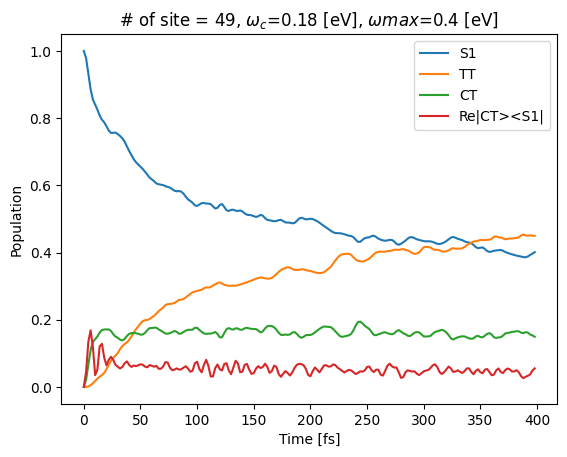

In [17]:
plt.title(f'# of site = {len(basis)}, $ω_c$={ωc} [eV], $ωmax$={ωmax} [eV]')
plt.ylabel('Population')
plt.xlabel('Time [fs]')
plt.plot(time_data, density_data_real[:, 0, 0], label="S1")
plt.plot(time_data, density_data_real[:, 1, 1], label="TT")
plt.plot(time_data, density_data_real[:, 2, 2], label="CT")
plt.plot(time_data, density_data_real[:, 0, 2], label="Re|CT><S1|")
plt.legend()
plt.show()

# time [fs]	S1         	N1         	N5         	N9         	N13        	N17        	N21        	N25        	N29        	N33        	N37        	N41        	N45
['#', 'time', '[fs]', 'S1', 'N1', 'N5', 'N9', 'N13', 'N17', 'N21', 'N25', 'N29', 'N33', 'N37', 'N41', 'N45']


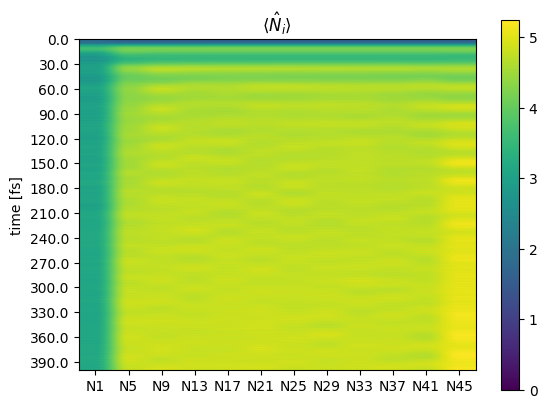

In [50]:
import polars as pl
import re

path = f"{jobname}_prop/expectations.dat"
with open(path, "r") as f:
    header = f.readline().strip()
    columns = re.split(r"\s+", header)
    columns = [columns[1]] + columns[3:]

    data = f.readlines()

df = pl.read_csv(
    path,
    separator="\t",
    new_columns=columns,
    has_header=False,
    skip_rows=1,
    schema_overrides={col: pl.Float64 for col in columns}, 
)
plt.imshow(df[columns[2:]], aspect=5.e-03)
plt.colorbar()
plt.ylabel('time [fs]')
plt.yticks(np.arange(len(df))[::150], df['time'][::150])
plt.xticks(np.arange(len(columns)-2), columns[2:])
plt.title(r'$\langle \hat{N}_i \rangle$')
plt.show()